## 1. Data Preparation for the capstone project: Clustering and forecasting electricity demand time-series

The goal of this project is to investigate whether it is possible to find an optimal model in terms of hyperparameters based on the shape of time-series. To achieve this goal, firstly sample time-series will be clustered into groups. Secondly, a same set of statistical models will be applied to a time-series from each cluster to train the model (and find the optimal set of hyperparameters) and compute the forecast.

The data set from Global Energy Forecasting Competition 2017 is used: Tao Hong, Jingrui Xie, and Jonathan Black, "Global Energy Forecasting Competition 2017: Hierarchical Probabilistic Load Forecasting," International Journal of Forecasting (http://blog.drhongtao.com/2019/04/gefcom2017-hierarchical-probabilistic-load-forecasting.html). Data contains the electricity demand from ISO New England, temperature and humidity time-series in hourly resolution. Electricity demand time-series are provided on a meter-level, whereas temperature and humidity are presumably per dispatch zone (there was no explanation of column headers provided in the data documentation).

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

Electricity demand time-series
--

In [38]:
load_data = pd.read_excel(os.path.join('GEFCom2017 Final Match','load.xlsx'),parse_dates=True) 

In [39]:
load_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397463 entries, 0 to 397462
Data columns (total 26 columns):
meter_id    397463 non-null int64
date        397463 non-null datetime64[ns]
h1          397462 non-null float64
h2          396377 non-null float64
h3          397462 non-null float64
h4          397462 non-null float64
h5          397462 non-null float64
h6          397462 non-null float64
h7          397462 non-null float64
h8          397462 non-null float64
h9          397462 non-null float64
h10         397462 non-null float64
h11         397463 non-null int64
h12         397463 non-null int64
h13         397463 non-null int64
h14         397463 non-null int64
h15         397463 non-null int64
h16         397463 non-null int64
h17         397463 non-null int64
h18         397463 non-null int64
h19         397463 non-null int64
h20         397463 non-null int64
h21         397463 non-null int64
h22         397463 non-null int64
h23         397463 non-null int64
h24       

In [40]:
load_data.head()

,meter_id,date,h1,h2,h3,h4,h5,h6,h7,h8,...,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24
0,1,2005-01-01,3304.0,3178.0,2981.0,2944.0,2934.0,2999.0,3104.0,3296.0,...,2270,2233,2330,2855,3020,3097,2994,2965,2776,2590
1,1,2005-01-02,2485.0,2448.0,2487.0,2553.0,2619.0,2900.0,3133.0,3399.0,...,2220,2193,2403,3012,3291,3236,3131,3002,2805,2569
2,1,2005-01-03,2417.0,2435.0,2448.0,2537.0,2674.0,2900.0,3385.0,3472.0,...,1915,1976,2257,2929,3256,3210,3078,2881,2543,2280
3,1,2005-01-04,2060.0,2018.0,2010.0,2094.0,2115.0,2327.0,2714.0,2758.0,...,1695,1760,1931,2514,2805,2782,2608,2496,2149,1829
4,1,2005-01-05,1629.0,1546.0,1569.0,1566.0,1650.0,1826.0,2288.0,2411.0,...,1668,1779,1923,2524,2821,2829,2632,2440,2133,1921


__a. Replace NaN__ 

Some of hourly measurements are missing, replace missing values with an average of neighbouring columns:

In [41]:
load_data.h2.fillna((load_data.h1 + load_data.h3)/2, inplace=True)

In [42]:
load_data[load_data.h1.isnull()]

,meter_id,date,h1,h2,h3,h4,h5,h6,h7,h8,...,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24
393015,481,2009-04-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7,0,8,8,7,0,8,8,0,7


Drop the row 393015 because ca 50% of values are missing:

In [43]:
load_data.drop(load_data.index[393015], inplace=True)

In [44]:
load_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397462 entries, 0 to 397462
Data columns (total 26 columns):
meter_id    397462 non-null int64
date        397462 non-null datetime64[ns]
h1          397462 non-null float64
h2          397462 non-null float64
h3          397462 non-null float64
h4          397462 non-null float64
h5          397462 non-null float64
h6          397462 non-null float64
h7          397462 non-null float64
h8          397462 non-null float64
h9          397462 non-null float64
h10         397462 non-null float64
h11         397462 non-null int64
h12         397462 non-null int64
h13         397462 non-null int64
h14         397462 non-null int64
h15         397462 non-null int64
h16         397462 non-null int64
h17         397462 non-null int64
h18         397462 non-null int64
h19         397462 non-null int64
h20         397462 non-null int64
h21         397462 non-null int64
h22         397462 non-null int64
h23         397462 non-null int64
h24       

__b. Convert demand data to float__

In [45]:
load_data.loc[:,'h11':'h24'] = load_data.loc[:,'h11':'h24'].astype(float)

__c. Transpose data into the vertical format__

For the analysis and modelling purposes, a matrix data format (with 24 measurements per row) has to be transposed into a vertical format (with 1 measurement per row):

In [46]:
df = load_data.set_index(['meter_id','date']).stack().reset_index()
df['level_2'] = df['level_2'].str.replace('h','').astype(int)
df['level_2'] = df['level_2']-1
df['date'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['level_2'].astype(str) + ':00:00')
df = df.drop('level_2', axis=1)
df['demand'] = df[0]
df = df.drop(0, axis=1)
df.head()

,meter_id,date,demand
0,1,2005-01-01 00:00:00,3304.0
1,1,2005-01-01 01:00:00,3178.0
2,1,2005-01-01 02:00:00,2981.0
3,1,2005-01-01 03:00:00,2944.0
4,1,2005-01-01 04:00:00,2934.0


__d. Add a time axis for modelling__

As a time axis for modelling, add a number of hours which has passed from the beginning of time-series for each meter:

In [47]:
min_date = df.groupby('meter_id').date.min()
df = df.merge(min_date, on='meter_id')
df['date_y'] = pd.to_datetime(df['date_y'].astype(str) + ' 00:00:00')
df['hours'] = (df.date_x - df.date_y).astype('timedelta64[h]')
df.drop('date_y', axis=1, inplace=True)
df = df.rename(columns={"date_x": "date"})
df.head()

,meter_id,date,demand,hours
0,1,2005-01-01 00:00:00,3304.0,0.0
1,1,2005-01-01 01:00:00,3178.0,1.0
2,1,2005-01-01 02:00:00,2981.0,2.0
3,1,2005-01-01 03:00:00,2944.0,3.0
4,1,2005-01-01 04:00:00,2934.0,4.0


Temperature and humidity time-series
--

In [48]:
temperature = pd.read_excel(os.path.join('GEFCom2017 Final Match','temperature.xlsx'),parse_dates=True) 
humidity = pd.read_excel(os.path.join('GEFCom2017 Final Match','relative humidity.xlsx'), parse_dates=True)

__a. Align time axes between demand and temperature time-series__

Check whether any dates are missing from the temperature and humidity time axes:

In [49]:
meter_1 = df[df['meter_id']==1]

In [50]:
assert meter_1.shape[0] == temperature.shape[0], 'Length of temperature and demand time-series do not match'

AssertionError: Length of temperature and demand time-series do not match

In [51]:
assert meter_1.shape[0] == humidity.shape[0], 'Length of humidity and demand time-series do not match'

AssertionError: Length of humidity and demand time-series do not match

Align time axes and add missing dates:

In [52]:
temperature.head()

,date,hr,t_ws1,t_ws2,t_ws3,t_ws4,t_ws5,t_ws6,t_ws7,t_ws8,...,t_ws19,t_ws20,t_ws21,t_ws22,t_ws23,t_ws24,t_ws25,t_ws26,t_ws27,t_ws28
0,2005-01-01,1,43.0,46,40.0,47.0,48.0,46.0,44.0,52.0,...,39.0,50.0,43.0,45.0,50.0,47.0,41.0,47.0,47.0,45.0
1,2005-01-01,2,41.0,46,38.0,46.0,48.0,45.0,51.0,50.0,...,41.0,49.0,43.0,46.0,47.0,47.0,45.0,47.0,47.0,45.0
2,2005-01-01,3,40.0,46,37.0,45.0,45.0,45.0,49.0,48.0,...,43.0,50.0,41.0,45.0,45.0,46.0,45.0,46.0,46.0,43.0
3,2005-01-01,4,39.0,46,37.0,47.0,48.0,48.0,45.0,50.0,...,43.0,49.0,41.0,43.0,45.0,44.0,45.0,47.0,47.0,44.0
4,2005-01-01,5,38.0,46,37.0,44.0,48.0,49.0,43.0,50.0,...,43.0,49.0,39.0,43.0,43.0,45.0,45.0,47.0,46.0,44.0


In [53]:
temperature['hours'] = temperature.hr-1
temperature['full_date'] = pd.to_datetime(temperature.date.astype('str') + ' ' + temperature.hours.astype('str') + ':00:00')
missing_dates = pd.DataFrame({'full_date': meter_1[meter_1.date.isin(temperature.full_date)==False].date})
missing_dates

,full_date
2209,2005-04-03 01:00:00
10945,2006-04-02 01:00:00
19177,2007-03-11 01:00:00
27913,2008-03-09 01:00:00
36649,2009-03-08 01:00:00
45553,2010-03-14 01:00:00
54289,2011-03-13 01:00:00


In [54]:
temperature = missing_dates.merge(temperature, how='outer', on='full_date', sort=True)
temperature.head()

,full_date,date,hr,t_ws1,t_ws2,t_ws3,t_ws4,t_ws5,t_ws6,t_ws7,...,t_ws20,t_ws21,t_ws22,t_ws23,t_ws24,t_ws25,t_ws26,t_ws27,t_ws28,hours
0,2005-01-01 00:00:00,2005-01-01,1.0,43.0,46.0,40.0,47.0,48.0,46.0,44.0,...,50.0,43.0,45.0,50.0,47.0,41.0,47.0,47.0,45.0,0.0
1,2005-01-01 01:00:00,2005-01-01,2.0,41.0,46.0,38.0,46.0,48.0,45.0,51.0,...,49.0,43.0,46.0,47.0,47.0,45.0,47.0,47.0,45.0,1.0
2,2005-01-01 02:00:00,2005-01-01,3.0,40.0,46.0,37.0,45.0,45.0,45.0,49.0,...,50.0,41.0,45.0,45.0,46.0,45.0,46.0,46.0,43.0,2.0
3,2005-01-01 03:00:00,2005-01-01,4.0,39.0,46.0,37.0,47.0,48.0,48.0,45.0,...,49.0,41.0,43.0,45.0,44.0,45.0,47.0,47.0,44.0,3.0
4,2005-01-01 04:00:00,2005-01-01,5.0,38.0,46.0,37.0,44.0,48.0,49.0,43.0,...,49.0,39.0,43.0,43.0,45.0,45.0,47.0,46.0,44.0,4.0


__b. Compute average hourly temperature__

Since no information was provided on t_ws columns in the data documentation, each value t_ws probably represents the temperature measurement per dispatch zone. An average temperature of all zones is be computed:

In [55]:
temperature['hourly_mean'] = temperature.iloc[:,2:30].mean(axis=1)

__c. Replace NaN in temperature time-series__

In [56]:
temperature.isnull().sum()

full_date      0
date           7
hr             7
t_ws1          7
t_ws2          7
t_ws3          7
t_ws4          7
t_ws5          7
t_ws6          7
t_ws7          7
t_ws8          7
t_ws9          7
t_ws10         7
t_ws11         7
t_ws12         7
t_ws13         7
t_ws14         7
t_ws15         7
t_ws16         7
t_ws17         7
t_ws18         7
t_ws19         7
t_ws20         7
t_ws21         7
t_ws22         7
t_ws23         7
t_ws24         7
t_ws25         7
t_ws26         7
t_ws27         7
t_ws28         7
hours          7
hourly_mean    7
dtype: int64

Fill NaN with previous values:

In [57]:
temperature.hourly_mean.fillna(method='ffill', inplace=True)

__d. Plot temperature data__

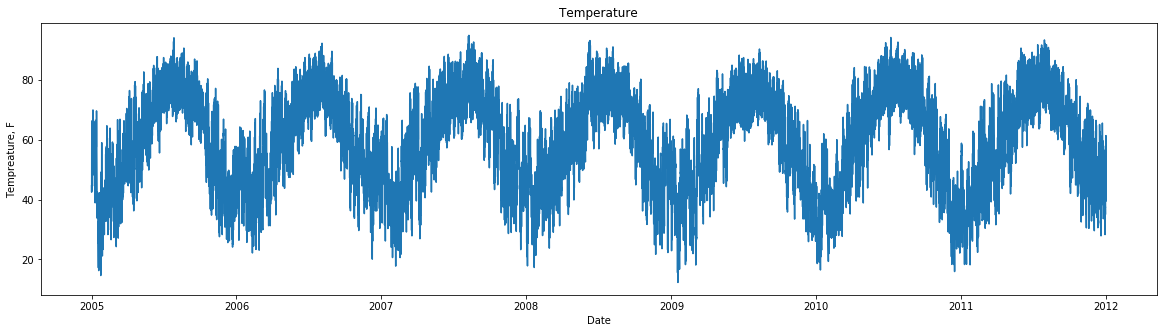

In [58]:
plt.figure(figsize=(20,5))
plt.plot(temperature.full_date, temperature.hourly_mean)
plt.xlabel('Date')
plt.ylabel('Tempreature, F')
plt.title('Temperature')
plt.show();

__e. Align time axes between demand and humidity time-series__

In [59]:
humidity['hours'] = humidity.hr-1
humidity['full_date'] = pd.to_datetime(humidity.date.astype('str') + ' ' + humidity.hours.astype('str') + ':00:00')
missing_dates = pd.DataFrame({'full_date': meter_1[meter_1.date.isin(humidity.full_date)==False].date})
missing_dates

,full_date
2209,2005-04-03 01:00:00
10945,2006-04-02 01:00:00
19177,2007-03-11 01:00:00
27913,2008-03-09 01:00:00
36649,2009-03-08 01:00:00
45553,2010-03-14 01:00:00
54289,2011-03-13 01:00:00


__f. Compute average hourly humidity__

In [60]:
humidity['hourly_mean'] = humidity.iloc[:,2:30].mean(axis=1)

__g. Replace NaN in humidity time-series__

In [61]:
humidity.isnull().sum()

date           0
hr             0
rh_ws1         0
rh_ws2         0
rh_ws3         0
rh_ws4         0
rh_ws5         0
rh_ws6         0
rh_ws7         0
rh_ws8         0
rh_ws9         0
rh_ws10        0
rh_ws11        0
rh_ws12        0
rh_ws13        0
rh_ws14        0
rh_ws15        0
rh_ws16        0
rh_ws17        0
rh_ws18        0
rh_ws19        0
rh_ws20        0
rh_ws21        0
rh_ws22        0
rh_ws23        0
rh_ws24        0
rh_ws25        0
rh_ws26        0
rh_ws27        0
rh_ws28        0
hours          0
full_date      0
hourly_mean    0
dtype: int64

In [62]:
humidity.hourly_mean.fillna(method='ffill', inplace=True)
humidity['hours'] = (humidity.full_date - humidity.date[0]).astype('timedelta64[h]')

__h. Plot humidity data__

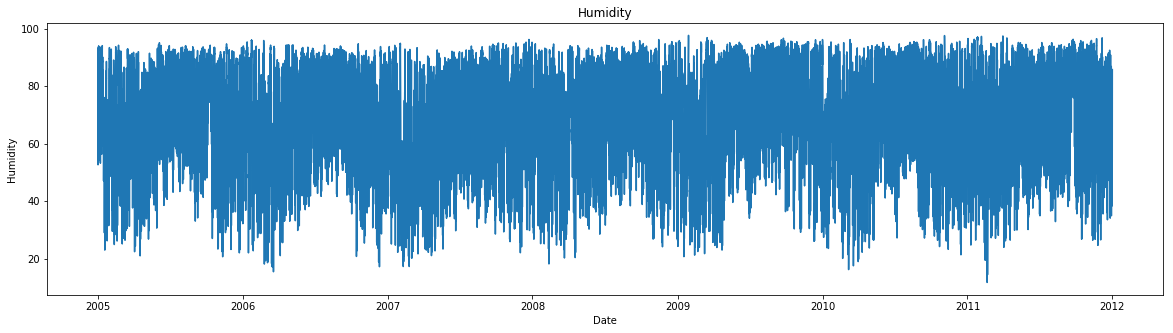

In [63]:
plt.figure(figsize=(20,5))
plt.plot(humidity.full_date, humidity.hourly_mean)
plt.xlabel('Date')
plt.ylabel('Humidity')
plt.title('Humidity')
plt.show()

__i. Remove unnecessary columns__

In [68]:
temperature.drop(['date','hr','hours','t_ws1','t_ws2','t_ws3',
                 't_ws4','t_ws5','t_ws6','t_ws7','t_ws8',
                 't_ws9','t_ws10','t_ws11','t_ws12','t_ws13',
                 't_ws14','t_ws15','t_ws16','t_ws17','t_ws18',
                 't_ws19','t_ws20','t_ws21','t_ws22','t_ws23',
                 't_ws24','t_ws25','t_ws26','t_ws27','t_ws28'], axis=1, inplace=True);

In [70]:
humidity.drop(['date','hr','hours','rh_ws1','rh_ws2','rh_ws3',
                 'rh_ws4','rh_ws5','rh_ws6','rh_ws7','rh_ws8',
                 'rh_ws9','rh_ws10','rh_ws11','rh_ws12','rh_ws13',
                 'rh_ws14','rh_ws15','rh_ws16','rh_ws17','rh_ws18',
                 'rh_ws19','rh_ws20','rh_ws21','rh_ws22','rh_ws23',
                 'rh_ws24','rh_ws25','rh_ws26','rh_ws27','rh_ws28'], axis=1, inplace=True);

Save cleaned data in dataframes:

In [71]:
import pickle

In [72]:
df.to_pickle('demand_data')
temperature.to_pickle('temperature')
humidity.to_pickle('humidity')